In [35]:
from datetime import datetime as d

import numpy as np
from numpy import linalg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math as m
np.set_printoptions(precision=4, suppress=True)

import math

# Outline (As recommended by 538's 2016 Election Model)
_Link:_ https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/

1) Collect, weight and average polls. 

2) Adjust polls for current trends and house effects.

3) Combine polls with demographic data through regression analysis to produce an electoral snapshot. 

_Sources:_
- https://github.com/davidasiegel/Nate_Silver_Presidential_Elections
- https://github.com/jseabold/538model/blob/master/silver_model.ipynb
    - Combined this with Ben Jones’ stuff
- https://github.com/jscottusf/election-dat
- https://github.com/benjones4747/silver/tree/5841d9a76ce78330c4ef701a3cc12a9e50097fdd/lib
    - Helpful with Step 1

## Step 1: Collect, Weight, and Average the Polls

#### Polls

In [36]:
#gathers polls from 538
poll = pd.read_csv('Relevant_Data/2020/president_polls.csv')
poll.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,answer,candidate_name,candidate_party,pct
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Biden,Joseph R. Biden Jr.,DEM,46.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Trump,Donald Trump,REP,40.0
2,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Biden,Joseph R. Biden Jr.,DEM,48.0
3,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Trump,Donald Trump,REP,45.0
4,120899,65227,2020,Georgia,1549,Battleground Connect,NaN,NaN,Battleground Connect,NaN,...,False,False,4/3/20 11:04,NaN,https://projects.fivethirtyeight.com/polls/202...,general,Biden,Joseph R. Biden Jr.,DEM,46.0


In [37]:
poll = poll[(poll['candidate_name'] == 'Joseph R. Biden Jr.') | (poll['candidate_name'] == 'Donald Trump')]
poll

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,answer,candidate_name,candidate_party,pct
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Biden,Joseph R. Biden Jr.,DEM,46.00
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Trump,Donald Trump,REP,40.00
2,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Biden,Joseph R. Biden Jr.,DEM,48.00
3,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Trump,Donald Trump,REP,45.00
4,120899,65227,2020,Georgia,1549,Battleground Connect,NaN,NaN,Battleground Connect,NaN,...,False,False,4/3/20 11:04,NaN,https://projects.fivethirtyeight.com/polls/202...,general,Biden,Joseph R. Biden Jr.,DEM,46.00
5,120899,65227,2020,Georgia,1549,Battleground Connect,NaN,NaN,Battleground Connect,NaN,...,False,False,4/3/20 11:04,NaN,https://projects.fivethirtyeight.com/polls/202...,general,Trump,Donald Trump,REP,48.00
6,121344,65668,2020,Michigan,1488,Spry Strategies,1260,American Principles Project,Spry Strategies,508.0,...,False,False,4/3/20 19:35,NaN,https://americanprinciplesproject.org/wp-conte...,general,Biden,Joseph R. Biden Jr.,DEM,45.81
7,121344,65668,2020,Michigan,1488,Spry Strategies,1260,American Principles Project,Spry Strategies,508.0,...,False,False,4/3/20 19:35,NaN,https://americanprinciplesproject.org/wp-conte...,general,Trump,Donald Trump,REP,46.12
8,120661,65041,2020,NaN,744,Ipsos,71,Reuters,Ipsos,154.0,...,False,False,3/31/20 19:15,NaN,https://www.reuters.com/article/us-usa-electio...,general,Biden,Joseph R. Biden Jr.,DEM,46.00
9,120661,65041,2020,NaN,744,Ipsos,71,Reuters,Ipsos,154.0,...,False,False,3/31/20 19:15,NaN,https://www.reuters.com/article/us-usa-electio...,general,Trump,Donald Trump,REP,40.00


#### Calculating Weighted Average (Recency, Pollster Rating, Sample Size)

In [38]:
pollster_weights = pd.read_csv('2018_Pollster_Rating - Sheet1.csv')
pollster_weights.head(5)

,Pollster,# of Polls,NCPP / AAPOR / Roper,Exclusively Live Caller With Cellphones,Methodology,Banned by 538,Historical Advanced Plus-Minus,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,...,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect
0,Selzer & Co.,43,yes,yes,Live,no,-1.9,-1.4,A+,R +0.0,...,4.2,5.6,-1.4,-1.9,-1.1,-1.4,30,R +0.0,R +0.0,D +0.1
1,Monmouth University,95,yes,yes,Live,no,-1.5,-1.3,A+,D +1.4,...,5.3,6.2,-0.8,-1.5,-1.1,-1.3,65,D +2.1,D +1.4,R +0.7
2,Field Research Corp. (Field Poll),25,yes,yes,Live,no,-2.5,-1.1,A+,R +1.2,...,3.9,5.7,-1.8,-2.5,-1.1,-1.1,18,R +3.3,R +1.2,D +0.6
3,ABC News/Washington Post,60,yes,yes,Live,no,-1.3,-1.1,A+,D +0.6,...,2.9,4.6,-1.8,-1.3,-0.9,-1.1,55,D +0.9,D +0.6,D +1.5
4,Elway Research,21,yes,yes,Live,no,-2.2,-1.1,A+,D +0.5,...,3.9,5.9,-1.9,-2.2,-0.9,-1.1,20,D +1.2,D +0.5,D +3.2


In [39]:
#HELPER FUNCTION 
def month(value):
    return value[0]

def year(value):
    return value[-2:]

In [40]:
polls = pd.merge(poll, pollster_weights, left_on = "pollster", right_on = "Pollster")
#for i in polls.columns:
    #print(i)

In [41]:
# Recency (most recent: 4/5/20)
# Need to use exponential decay to compare the polling time to the election date
# Caveat: Being farther out from election day makes polls kind of useless
# Our code predicts if the elections were to happen on April 5th, 2020

def exp_decay(days):
    days = getattr(days, "days", days)
    return .5 ** (days/30.)

def ageweight(raw):
    raw['age_weight'] = 0.0
    for index, row in raw.iterrows():
        d0 = ('4/5/20')
        d0 = d.strptime(d0, '%m/%d/%y')
        date = row['end_date']
        d1 = d.strptime(date, '%m/%d/%y')
        delta = d0 - d1
        diff = delta.days
        age_weight = exp_decay(diff)
        raw.at[index,'recency_weight'] = age_weight
    return

ageweight(polls)

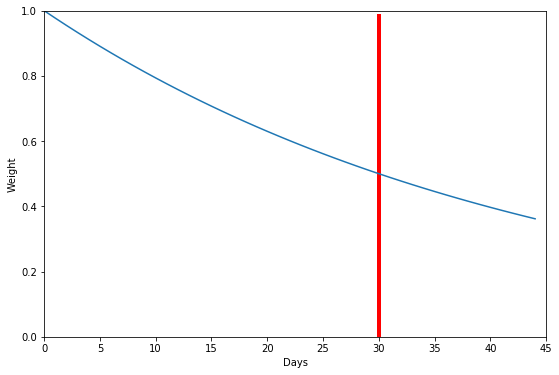

In [42]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={"xlabel" : "Days",
                                                   "ylabel" : "Weight"})
days = np.arange(0, 45)
ax.plot(days, exp_decay(days));
ax.vlines(30, 0, .99, color='r', linewidth=4)
ax.set_ylim(0,1)
ax.set_xlim(0, 45);

In [43]:
polls[['end_date','recency_weight']]

,end_date,recency_weight
0,4/4/20,0.977160
1,4/4/20,0.977160
2,2/18/20,0.337587
3,2/18/20,0.337587
4,2/18/20,0.337587
5,2/18/20,0.337587
6,2/18/20,0.337587
7,2/18/20,0.337587
8,2/18/20,0.337587
9,10/20/19,0.020617


In [44]:
# Pollster Rating
def weight(x):
    #i think this weight i based on the 2016 elections
    newx = float(1 - (1/(3.025044 + 1.200763)) * (x + 1.200763))
    return newx

def apply_weights(pr):
    pr['pollster_weight'] = 0.0
    for index, row in pr.iterrows():
        x = row['Predictive Plus-Minus']
        if row['Banned by 538'] == 'yes':
            newx = 0.0
        else:
            newx = weight(x)
        pr.at[index,'pollster_weight'] = newx
    return pr

In [45]:
apply_weights(polls)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
5,118577,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
6,118578,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
7,118579,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
8,118580,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
9,111116,62230,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.020617,0.810506


In [46]:
# Sample size (based on how Nate Silver used it in 2008)
mean = np.mean(polls['sample_size'])
polls['sample_size_weight'] = (polls['sample_size']/mean)**2
polls[['sample_size', 'sample_size_weight']]

,sample_size,sample_size_weight
0,3244.0,4.630496
1,3244.0,4.630496
2,672.0,0.198703
3,668.0,0.196344
4,668.0,0.196344
5,671.0,0.198112
6,661.0,0.192251
7,664.0,0.194000
8,662.0,0.192833
9,644.0,0.182489


In [47]:
# Get weighted averages
polls['weighted_average'] = polls['recency_weight'] * polls['pollster_weight'] * polls['sample_size_weight']

def weighted_average(df):
    weights1 = df['recency_weight']
    weights2 = df['pollster_weight']
    weights3 = df['sample_size_weight']
    return weights1*weights2*weights3
    
state_polls = polls.groupby(['state', 'pollster']).apply(weighted_average)

In [48]:
polls.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.630496,3.667327
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.630496,3.667327
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.198703,0.054368
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.196344,0.053723
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.196344,0.053723


In [49]:
polls

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.630496,3.667327
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.630496,3.667327
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.198703,0.054368
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.196344,0.053723
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.196344,0.053723
5,118577,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.198112,0.054207
6,118578,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.192251,0.052603
7,118579,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.194000,0.053082
8,118580,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.192833,0.052762
9,111116,62230,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.020617,0.810506,0.182489,0.003049


In [50]:
polls['state'].unique()

array(['Florida', 'Michigan', 'California', 'Wisconsin', 'Kansas',
       'Maine', 'Arizona', 'Iowa', 'Washington', 'Maine CD-1',
       'Maine CD-2', 'Ohio', 'North Carolina', nan, 'Texas',
       'Pennsylvania', 'South Carolina', 'New York', 'New Mexico',
       'New Hampshire', 'Nevada', 'Colorado', 'Massachusetts', 'Georgia',
       'North Dakota', 'Minnesota', 'Mississippi', 'Alabama', 'Tennessee',
       'Virginia', 'Missouri', 'New Jersey', 'Oklahoma', 'Delaware',
       'Alaska', 'Kentucky', 'Utah'], dtype=object)

In [51]:
rep_points = []
dem_points = []
for i in polls['state'].unique():
    start = polls[polls['state'] == i]
    for j in start['pollster'].unique():
        mid = start[start['pollster'] == j]
        mid = mid.sort_values(by = 'end_date').reset_index(drop=True)
        rep = mid[mid['candidate_name'] == 'Donald Trump'].reset_index(drop=True)
        dem = mid[mid['candidate_name'] == 'Joseph R. Biden Jr.'].reset_index(drop=True)
        if len(rep) > 1:
            rep_points.append([i,j,((rep.loc[0]['pct'] - rep.loc[len(rep)-1]['pct'])*(-1))])
        elif len(rep) == 1:
            rep_points.append([i,j,0])
        if len(dem) > 1:
            dem_points.append([i,j,(dem.loc[0]['pct'] - dem.loc[len(dem)-1]['pct'])])
        elif len(dem) == 1:
            dem_points.append([i,j,0])

In [52]:
loess_df_1 = polls.copy()
loess_df_1['spread'] = "NAN " + str(0)

for i in rep_points: 
    loess_df_1.loc[(loess_df_1.state == i[0]) & (loess_df_1['pollster'] == i[1]),'spread'] = ("REP " + str(i[2]))
    
for i in dem_points: 
    loess_df_1.loc[(loess_df_1.state == i[0]) & (loess_df_1['pollster'] == i[1]),'spread'] = ("DEM " + str(i[2]))

polls = loess_df_1.reset_index(drop=True)
polls

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average,spread
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.630496,3.667327,DEM 2.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.630496,3.667327,DEM 2.0
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.198703,0.054368,DEM 2.0
3,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.196344,0.053723,DEM 2.0
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.196344,0.053723,DEM 2.0
5,118577,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.198112,0.054207,DEM 2.0
6,118578,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.192251,0.052603,DEM 2.0
7,118579,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.194000,0.053082,DEM 2.0
8,118580,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.192833,0.052762,DEM 2.0
9,111116,62230,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.020617,0.810506,0.182489,0.003049,DEM 2.0


## Step 2: Adjust polls

* Trend line adjustment 

In [53]:
pvi = pd.read_csv("Relevant_Data/2020/fivethirtyeight_partisan_lean_STATES copy.csv")
pvi.head()

,state,pvi_538
0,Alabama,R+27
1,Alaska,R+15
2,Arizona,R+9
3,Arkansas,R+24
4,California,D+24


In [54]:
pvi.set_index("state", inplace=True);
pvi.head()

,pvi_538
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [55]:
pvi.columns = ['PVI']
pvi.head()

,PVI
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [56]:
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

state
Alabama          -27.0
Alaska           -15.0
Arizona           -9.0
Arkansas         -24.0
California        24.0
Colorado           1.0
Connecticut       11.0
Delaware          14.0
Florida           -5.0
Georgia          -12.0
Hawaii            36.0
Idaho            -35.0
Illinois          13.0
Indiana          -18.0
Iowa              -6.0
Kansas           -23.0
Kentucky         -23.0
Louisiana        -17.0
Maine              5.0
Maryland          23.0
Massachusetts     29.0
Michigan           1.0
Minnesota          2.0
Mississippi      -15.0
Missouri         -19.0
Montana          -18.0
Nebraska         -24.0
Nevada            -1.0
New Hampshire     -2.0
New Jersey        13.0
New Mexico         7.0
New York          22.0
North Carolina    -5.0
North Dakota     -33.0
Ohio              -7.0
Oklahoma         -34.0
Oregon             9.0
Pennsylvania      -1.0
Rhode Island      26.0
South Carolina   -17.0
South Dakota     -31.0
Tennessee        -28.0
Texas            -17.0
Utah 

In [57]:
party_affil = pd.read_csv("party_affiliation_by_state.csv")
party_affil =party_affil.rename(columns={'Unnamed: 0': "State", 'Democrat/Lean Democratic': 'Democrat', 
                           'Republican/Lean Republican': 'Republican', 
                            'Democratic advantage':'Dem_Adv'}).set_index("State")[1:53]
party_affil

,Democrat,Republican,Dem_Adv,N,Classification
State,,,,,
U.S.,45,38,7,"180,106",Lean Dem
Maine,47,39,8,941,Lean Dem
New Hampshire,43,40,3,831,Competitive
Vermont,52,30,22,496,Solid Dem
Massachusetts,57,26,31,"3,805",Solid Dem
Rhode Island,48,27,21,602,Solid Dem
Connecticut,51,32,19,"2,020",Solid Dem
New York,52,29,23,"10,864",Solid Dem
New Jersey,48,33,15,"4,455",Solid Dem


In [58]:
party_affil.columns

Index(['Democrat', 'Republican', 'Dem_Adv', 'N', 'Classification'], dtype='object')

In [59]:
party_affil['Democrat'] = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican
party_affil

,Democrat,Republican,Dem_Adv,N,Classification,no_party
State,,,,,,
U.S.,45.0,38.0,7,"180,106",Lean Dem,17.0
Maine,47.0,39.0,8,941,Lean Dem,14.0
New Hampshire,43.0,40.0,3,831,Competitive,17.0
Vermont,52.0,30.0,22,496,Solid Dem,18.0
Massachusetts,57.0,26.0,31,"3,805",Solid Dem,17.0
Rhode Island,48.0,27.0,21,602,Solid Dem,25.0
Connecticut,51.0,32.0,19,"2,020",Solid Dem,17.0
New York,52.0,29.0,23,"10,864",Solid Dem,19.0
New Jersey,48.0,33.0,15,"4,455",Solid Dem,19.0


In [101]:
#Census
census_data = pd.read_csv("Census_Data.csv")
census_data.head()

,State,Total_Pop_2019,Under_18,Over_65,Black,Native American,Hispanic,Non-Hispanic,High_School_Grad,Bachelor_Degree,Per_Capita_Income,Median_Household_Income_2018,Pop_Per_Sq_Mile_2010
0,Alabama,"4,903,185",22.30%,16.90%,26.80%,0.70%,4.40%,65.40%,85.80%,24.90%,"$26,846","$48,486",94.4
1,Alaska,"731,545",24.90%,11.80%,3.80%,15.40%,7.20%,60.30%,92.70%,29.20%,"$35,874","$76,715",1.2
2,Arizona,"7,278,717",22.90%,17.50%,5.10%,5.30%,31.60%,54.40%,86.80%,28.90%,"$29,265","$56,213",56.3
3,Arkansas,"3,017,804",23.30%,17.00%,15.70%,1.00%,7.70%,72.20%,86.20%,22.60%,"$25,635","$45,726",56
4,California,"39,512,223",22.70%,14.30%,6.50%,1.60%,39.30%,36.80%,82.90%,33.30%,"$35,021","$71,228",239.1


In [102]:
census_refined = pd.DataFrame({})

census_data.rename(columns={
                        "Median_Household_Income_2018" : "median_income",
                        "Per_Capita_Income" : "average_income",
                        "Pop_Per_Sq_Mile_2010" : "pop_density",
                        "High_School_Grad" : "educ_hs",
                        "Bachelor_Degree" : "educ_coll",
                        "Non-Hispanic " : "per_white",
                        "Hispanic" : "per_hisp",
                        "State" : "state",
                        "Black" : "per_black",
                                }, inplace=True)

census_data.head(5)

,state,Total_Pop_2019,Under_18,Over_65,per_black,Native American,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density
0,Alabama,"4,903,185",22.30%,16.90%,26.80%,0.70%,4.40%,65.40%,85.80%,24.90%,"$26,846","$48,486",94.4
1,Alaska,"731,545",24.90%,11.80%,3.80%,15.40%,7.20%,60.30%,92.70%,29.20%,"$35,874","$76,715",1.2
2,Arizona,"7,278,717",22.90%,17.50%,5.10%,5.30%,31.60%,54.40%,86.80%,28.90%,"$29,265","$56,213",56.3
3,Arkansas,"3,017,804",23.30%,17.00%,15.70%,1.00%,7.70%,72.20%,86.20%,22.60%,"$25,635","$45,726",56
4,California,"39,512,223",22.70%,14.30%,6.50%,1.60%,39.30%,36.80%,82.90%,33.30%,"$35,021","$71,228",239.1


In [103]:
tot_pop = census_data["Total_Pop_2019"].str.replace(",","").astype(float)
per_18 = census_data["Under_18"].str.strip('%').astype(float)/100 # under 18
per_65 = census_data["Over_65"].str.strip('%').astype(float)/100 # over 65
older_pop = per_65*tot_pop
vote_pop = tot_pop - per_18*tot_pop - older_pop
census_data["vote_pop"] = vote_pop
census_data["older_pop"] = older_pop
census_data["per_older"] = older_pop / tot_pop
census_data["per_vote"] = vote_pop / tot_pop


del census_data["Total_Pop_2019"]
del census_data["Under_18"]
del census_data["Over_65"]
del census_data["Native American"]

In [104]:
columns = ['per_black', 'per_hisp', 'per_white', 'educ_hs', 'educ_coll']
columns_1 = ['average_income', 'median_income']

for i in columns:
    census_data[i] = census_data[i].str.strip('%').astype(float)
    
for i in columns_1:
    census_data[i] = census_data[i].str.strip('$')
    census_data[i] = census_data[i].str.replace(',','').astype(float)

In [105]:
census_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
0,Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608
1,Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633
2,Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596
3,Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597
4,California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630


In [106]:
census_data.set_index("state", inplace=True)

In [107]:
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
state,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630


In [108]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [109]:
#Campaign Contributions

trump_contributions = pd.read_csv('Trump_Contributions.csv')
trump_contributions = trump_contributions[['state','amount']]
trump_give = trump_contributions.groupby('state').sum()
trump_give.head()

,amount
state,
AK,207571.54
AL,771455.87
AR,356147.43
AZ,1713691.27
CA,9474707.89


In [170]:
biden_contributions = pd.read_csv('Biden_Contributions.csv')
biden_contributions = biden_contributions[['state','amount']]
biden_give = biden_contributions.groupby('state').sum()
biden_give.head()

,amount
state,
AK,38290.30
AL,206558.37
AR,72624.75
AZ,287279.67
CA,7670810.88


In [116]:
biden_give = biden_give.reset_index()
biden_give['state'] = biden_give.state.replace(states_abbrev_dict)

trump_give = trump_give.reset_index()
trump_give['state'] = trump_give.state.replace(states_abbrev_dict)

biden_give.set_index("state", inplace=True)
trump_give.set_index("state", inplace=True);

In [117]:
demo_data = census_data.join(party_affil[["Dem_Adv", "no_party"]]).join(pvi)
demo_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI
state,,,,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15,15.0,-27.0
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21,17.0,-15.0
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2,18.0,-9.0
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597,-9,19.0,-24.0
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21,19.0,24.0


In [118]:
demo_data = demo_data.join(biden_give, on='state',rsuffix = '_biden')
demo_data = demo_data.join(trump_give, on='state', rsuffix = '_trump')
demo_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI,amount,amount_trump
state,,,,,,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15,15.0,-27.0,206558.37,771455.87
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21,17.0,-15.0,38290.30,207571.54
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2,18.0,-9.0,287279.67,1713691.27
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597,-9,19.0,-24.0,72624.75,356147.43
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21,19.0,24.0,7670810.88,9474707.89


In [120]:
demo_data.columns

Index(['per_black', 'per_hisp', 'per_white', 'educ_hs', 'educ_coll',
       'average_income', 'median_income', 'pop_density', 'vote_pop',
       'older_pop', 'per_older', 'per_vote', 'Dem_Adv', 'no_party', 'PVI',
       'amount', 'amount_trump'],
      dtype='object')

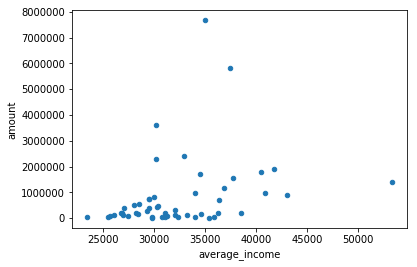

In [184]:
demo_data.plot.scatter(x="average_income", y="amount")

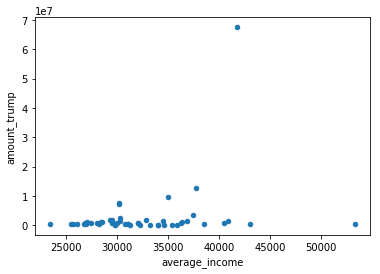

In [185]:
demo_data.plot.scatter(x="average_income", y="amount_trump")

In [122]:
pip install plotly

    100% |████████████████████████████████| 7.2MB 2.9MB/s eta 0:00:01 1% |▎                               | 71kB 1.6MB/s eta 0:00:05
  Stored in directory: /Users/sudisarvepalli/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [152]:
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [126]:
type(demo_data.index)

pandas.core.indexes.base.Index

#### per_black demographic visualization

In [171]:

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = demo_data['per_black'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#### per_hisp demographic visualization

In [174]:

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = demo_data['per_hisp'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#### per_white demographic visualization

In [176]:

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = demo_data['per_white'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#### fec_biden visualization

In [177]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = demo_data['amount'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#### fec_trump visualization

In [179]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = demo_data['amount_trump'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#### correlation matrix

In [191]:
demo_data.corr()[['amount', 'amount_trump']]

,amount,amount_trump
per_black,0.172067,-0.002696
per_hisp,0.489376,0.112234
per_white,-0.444446,-0.064379
educ_hs,-0.382779,-0.039135
educ_coll,0.276476,0.286717
average_income,0.305785,0.268825
median_income,0.285828,0.259739
vote_pop,0.858827,0.207489
older_pop,0.858228,0.204933
per_older,-0.120084,-0.032716


There are weak correlations between all the demographics data to the fec contributions for each candidate.

In [ ]:
giving = demo_data[["amount", "amount_trump"]].div(demo_data[["vote_pop", "older_pop"]].sum(1), axis=0)
giving.head()

In [ ]:
demo_data[["amount", "amount_trump"]] = giving

In [ ]:
#pop_density
#Dem_adv
demo_data['pop_density'] = demo_data['pop_density'].str.replace(',','').astype(float)
demo_data['Dem_Adv'] = demo_data['Dem_Adv'].astype(float)
demo_data = demo_data.drop('District of Columbia', axis = 0)
demo_data.head()

In [ ]:
from scipy import cluster as sp_cluster
from sklearn import cluster, neighbors

In [ ]:
clean_data = sp_cluster.vq.whiten(demo_data.values)

In [ ]:
clean_data.var(axis=0)

In [ ]:
KNN = neighbors.NearestNeighbors(n_neighbors=7)
KNN.fit(clean_data)
KNN.kneighbors(clean_data[0].reshape(1,-1), return_distance=True)

In [ ]:
demo_data.index[0], demo_data.index[KNN.kneighbors(clean_data[0].reshape(1,-1), return_distance=True)[1][0]]

In [ ]:
nearest_neighbor = {}
for i, state in enumerate(demo_data.index):
    neighborhood = KNN.kneighbors(clean_data[i].reshape(1,-1), return_distance=True)
    nearest_neighbor.update({state : (demo_data.index[neighborhood[1]],
                                     neighborhood[0])})

In [ ]:
nearest_neighbor

In [ ]:
k_means = cluster.KMeans(n_clusters=5, n_init=50)
k_means.fit(clean_data)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
labels

In [ ]:
clusters = sp_cluster.vq.kmeans(clean_data, 5)[0]
clusters

In [ ]:
def choose_group(data, clusters):
    """
    Return the index of the cluster to which the rows in data
    are "closest" (in the sense of the L2-norm)
    """
    data = data[:,None] # add an axis for broadcasting
    distances = data - clusters
    groups = []
    for row in distances:
        dists = map(np.linalg.norm, row)
        groups.append(np.argmin(list(dists)))
    return groups

In [ ]:
groups = choose_group(clean_data, clusters)
np.array(groups)

In [ ]:
demo_data["kmeans_group"] = groups
demo_data["kmeans_labels"] = labels

In [ ]:
for _, group in demo_data.groupby("kmeans_group"):
    group = group.index
    group.values.sort()
    print (group.values)

In [ ]:
demo_data["kmeans_labels"] = labels
for _, group in demo_data.groupby("kmeans_labels"):
    group = group.index.copy()
    group.values.sort()
    print (group.values)

In [ ]:
demo_data = demo_data.reset_index()
demo_data.head()

In [ ]:
polls.state.replace(states_abbrev_dict, inplace=True)
polls = polls.merge(demo_data[["state", "kmeans_labels"]], on="state")
polls.head()

In [ ]:
kmeans_groups = polls.groupby("kmeans_labels")
kmeans_groups.groups.keys()

In [ ]:
group = kmeans_groups.get_group(list(kmeans_groups.groups.keys())[2])
group

In [ ]:
group.state.unique()

In [ ]:
rep_points = []
dem_points = []
for i in group['state'].unique():
    start = group[group['state'] == i]
    for j in start['pollster'].unique():
        mid = start[start['pollster'] == j]
        mid = mid.sort_values(by = 'end_date').reset_index(drop=True)
        rep = mid[mid['candidate_party'] == 'REP'].reset_index(drop=True)
        dem = mid[mid['candidate_party'] == 'DEM'].reset_index(drop=True)
        if len(rep) > 1:
            rep_points.append([i,j,((rep.loc[0]['pct'] - rep.loc[len(rep)-1]['pct'])*(-1))])
        elif len(rep) == 1:
            rep_points.append([i,j,0])
        if len(dem) > 1:
            dem_points.append([i,j,(dem.loc[0]['pct'] - dem.loc[len(dem)-1]['pct'])])
        elif len(dem) == 1:
            dem_points.append([i,j,0])

In [ ]:
loess_df = group.copy()
loess_df['spread'] = "NAN " + str(0)

for i in rep_points: 
    loess_df.loc[(loess_df.state == i[0]) & (loess_df['pollster'] == i[1]),'spread'] = "REP " + str(i[2])
    
for i in dem_points: 
    loess_df.loc[(loess_df.state == i[0]) & (loess_df['pollster'] == i[1]),'spread'] = "DEM " + str(i[2])

loess_df = loess_df.reset_index(drop=True)

In [ ]:
def edit_tick_label(tick_val, tick_pos):
    if 'DEM' in tick_val:
        text = tick_val.replace("DEM", "BIDEN")
    else:
        text = tick_val.replace("REP", "TRUMP")
    return text

In [ ]:
def number(val):
    val = val[4:]
    return val

In [ ]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(figsize=(12,8))

data = loess_df[["end_date", "spread"]]
data = pd.concat((data, loess_df_1[["end_date", "spread"]])).reset_index(drop=True)
    
dates = pd.to_datetime(data.end_date)

data['spread'] = data['spread'].apply(lambda x: number(x))
data['spread'] = data['spread'].astype(float)

loess_res = sm.nonparametric.lowess(data.spread.values, dates, frac=0.2, it=50)

axes.scatter(dates, data["spread"])
axes.plot(dates, loess_res[:,1], color='r', lw = 0.5)
axes.yaxis.get_major_locator().set_params(nbins=20)
#axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='y')
axes.margins(0, .05)

In [ ]:
loess_res[-7:,1].mean()

In [ ]:
trends = []
for i,group in kmeans_groups:
    data = group[["end_date", "spread"]]
    data = pd.concat((data, polls[["end_date", "spread"]]))
    
    dates = pd.DatetimeIndex(data.end_date).asi8
    
    data['spread'] = data['spread'].apply(lambda x: number(x))
    data['spread'] = data['spread'].astype(float)

    loess_res = sm.nonparametric.lowess(data.spread.values, dates, frac=.5, it=3)
    
    states = group.state.unique()
    
    for state in states:
        trends.append([state, loess_res[-7:,1].mean()])

In [ ]:
trends

## Snapshot

In [ ]:
state_polls.name = "poll"
state_polls

In [ ]:
state_polls = state_polls.reset_index()
state_polls.state = state_polls.state.replace(states_abbrev_dict)
state_polls = state_polls.drop(['level_2'], axis = 1)

In [ ]:
state_polls.groupby('state').mean()

In [ ]:
#trends.name = "poll"
trends = pd.DataFrame(data = trends)
trends = trends.rename({0: 'state', 1: 'trend'}, axis='columns')
trends.head()

In [ ]:
polls = state_polls.merge(trends, on = 'state')
polls

In [ ]:
polls['poll'] = polls['poll'] * polls['trend']
polls = polls.drop('trend', axis = 1)

In [ ]:
results = polls.groupby("state").mean()
results

In [ ]:
electoral_votes = pd.read_csv('electoral_votes.csv')
electoral_votes.head()

In [ ]:
results = results.reset_index()
results["biden"] = 0
results["trump"] = 0
results.loc[(results["poll"] > 0), "biden"] = 1
results.loc[(results["poll"] < 0), "trump"] = 1
results

In [ ]:
results = results.merge(electoral_votes, left_on = 'state', right_on = 'State')
results

In [ ]:
results["Votes"].mul(results["biden"]).sum()

In [ ]:
results["Votes"].mul(results["trump"]).sum()